In [1]:
import h5py
import numpy as np
import glob, os, re, sys
import pickle

import astro_helper as ah
import networkx as nx
import graphviz
import pydot

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import rc
plt.style.use('bmh')
rc('font',**{'family':'DejaVu Sans','sans-serif':['Helvetica']})

In [3]:
# load the merger tree
mergertree_name = './merger_tree_500-799.pkl'
width = 12. # diameter of galaxy in kpc
with open(mergertree_name, 'rb') as f:
    G = pickle.load(f)

In [5]:
# order the clouds/nodes by time
time_dict = nx.get_node_attributes(G, 'time')
min_time, max_time = np.min(list(time_dict.values())), np.max(list(time_dict.values()))
print(min_time, max_time)

node_groups = ah.sort_by_time(list(time_dict.keys()), list(time_dict.values()))

0.5000244140625 0.7980468749999999


In [6]:
# remove weakly-connected components of the directed graph that touch the
# start/end times or touch the maximum galactocentric radius, as these
# may be incomplete

wcs = nx.weakly_connected_components(G)

wcs_cmplt, wcs_cmplt_lens = [], []
for wc in wcs:
    G_wc = G.subgraph(wc)
    times_wc = np.unique(list(nx.get_node_attributes(G_wc, 'time').values()))
    xs_cent_wc, ys_cent_wc, zs_cent_wc = zip(*list(nx.get_node_attributes(G_wc, 'centroid').values()))
    xs_cent_wc = np.array(list(xs_cent_wc))
    ys_cent_wc = np.array(list(ys_cent_wc))
    Rs_cent_wc = np.sqrt(xs_cent_wc**2 + ys_cent_wc**2)/ah.kpc_to_cm
    
    min_time_wc, max_time_wc = np.min(times_wc), np.max(times_wc)
    min_radius_wc, max_radius_wc = np.min(Rs_cent_wc), np.max(Rs_cent_wc)
    
    if (min_time_wc > min_time) & (max_time_wc < max_time) & (max_radius_wc < width/2.):
        wcs_cmplt.append(list(wc))
        wcs_cmplt_lens.append(len(list(wc)))

G_cmplt = G.subgraph(set(ah.flatten_list(wcs_cmplt)))

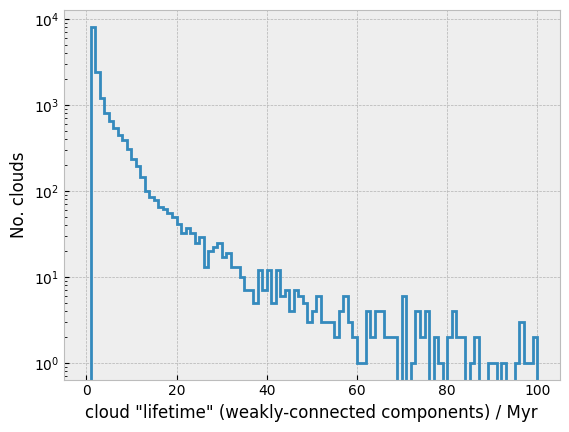

In [9]:
plt.hist(wcs_cmplt_lens, bins=np.linspace(0., 100, 101), log=True, histtype='step', lw=2)
plt.xlabel('cloud "lifetime" (weakly-connected components) / Myr')
plt.ylabel('No. clouds')
plt.show()

In [10]:
# look at a small section of the merger tree by plotting with PyDot
G_reduced = G.subgraph(set(ah.flatten_list(wcs_cmplt[:50])))
P = nx.nx_pydot.to_pydot(G_reduced)
times_keys = [node for node in P.get_nodes()]
times_values = [float(node.get_attributes()['time']) for node in P.get_nodes()]

time_groups = ah.sort_by_time(times_keys, times_values)

/tmp/ipykernel_1062287/1504798840.py:3: DeprecationWarning: nx.nx_pydot.to_pydot depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  P = nx.nx_pydot.to_pydot(G_reduced)


In [11]:
# scale the size of the nodes according to the logarithm of the mass
min_mass = np.min(list(nx.get_node_attributes(G_reduced, 'mass').values()))
max_mass = np.max(list(nx.get_node_attributes(G_reduced, 'mass').values()))
log_min_mass = np.log10(min_mass)

for nodes_set in time_groups:
    S = pydot.Subgraph(rank="same")
    for node in nodes_set:
        mass = float(node.get_attributes()["mass"])
        node.set_style("filled")
        node.set_shape("circle")
        node.set_fixedsize(True)
        #node.set_height(.3)
        node.set_height((np.log10(mass) - log_min_mass)/10)
        node.set_label("")
        S.add_node(node)

    P.add_subgraph(S)

In [12]:
P.write_png(mergertree_name.replace("pkl", "png"))

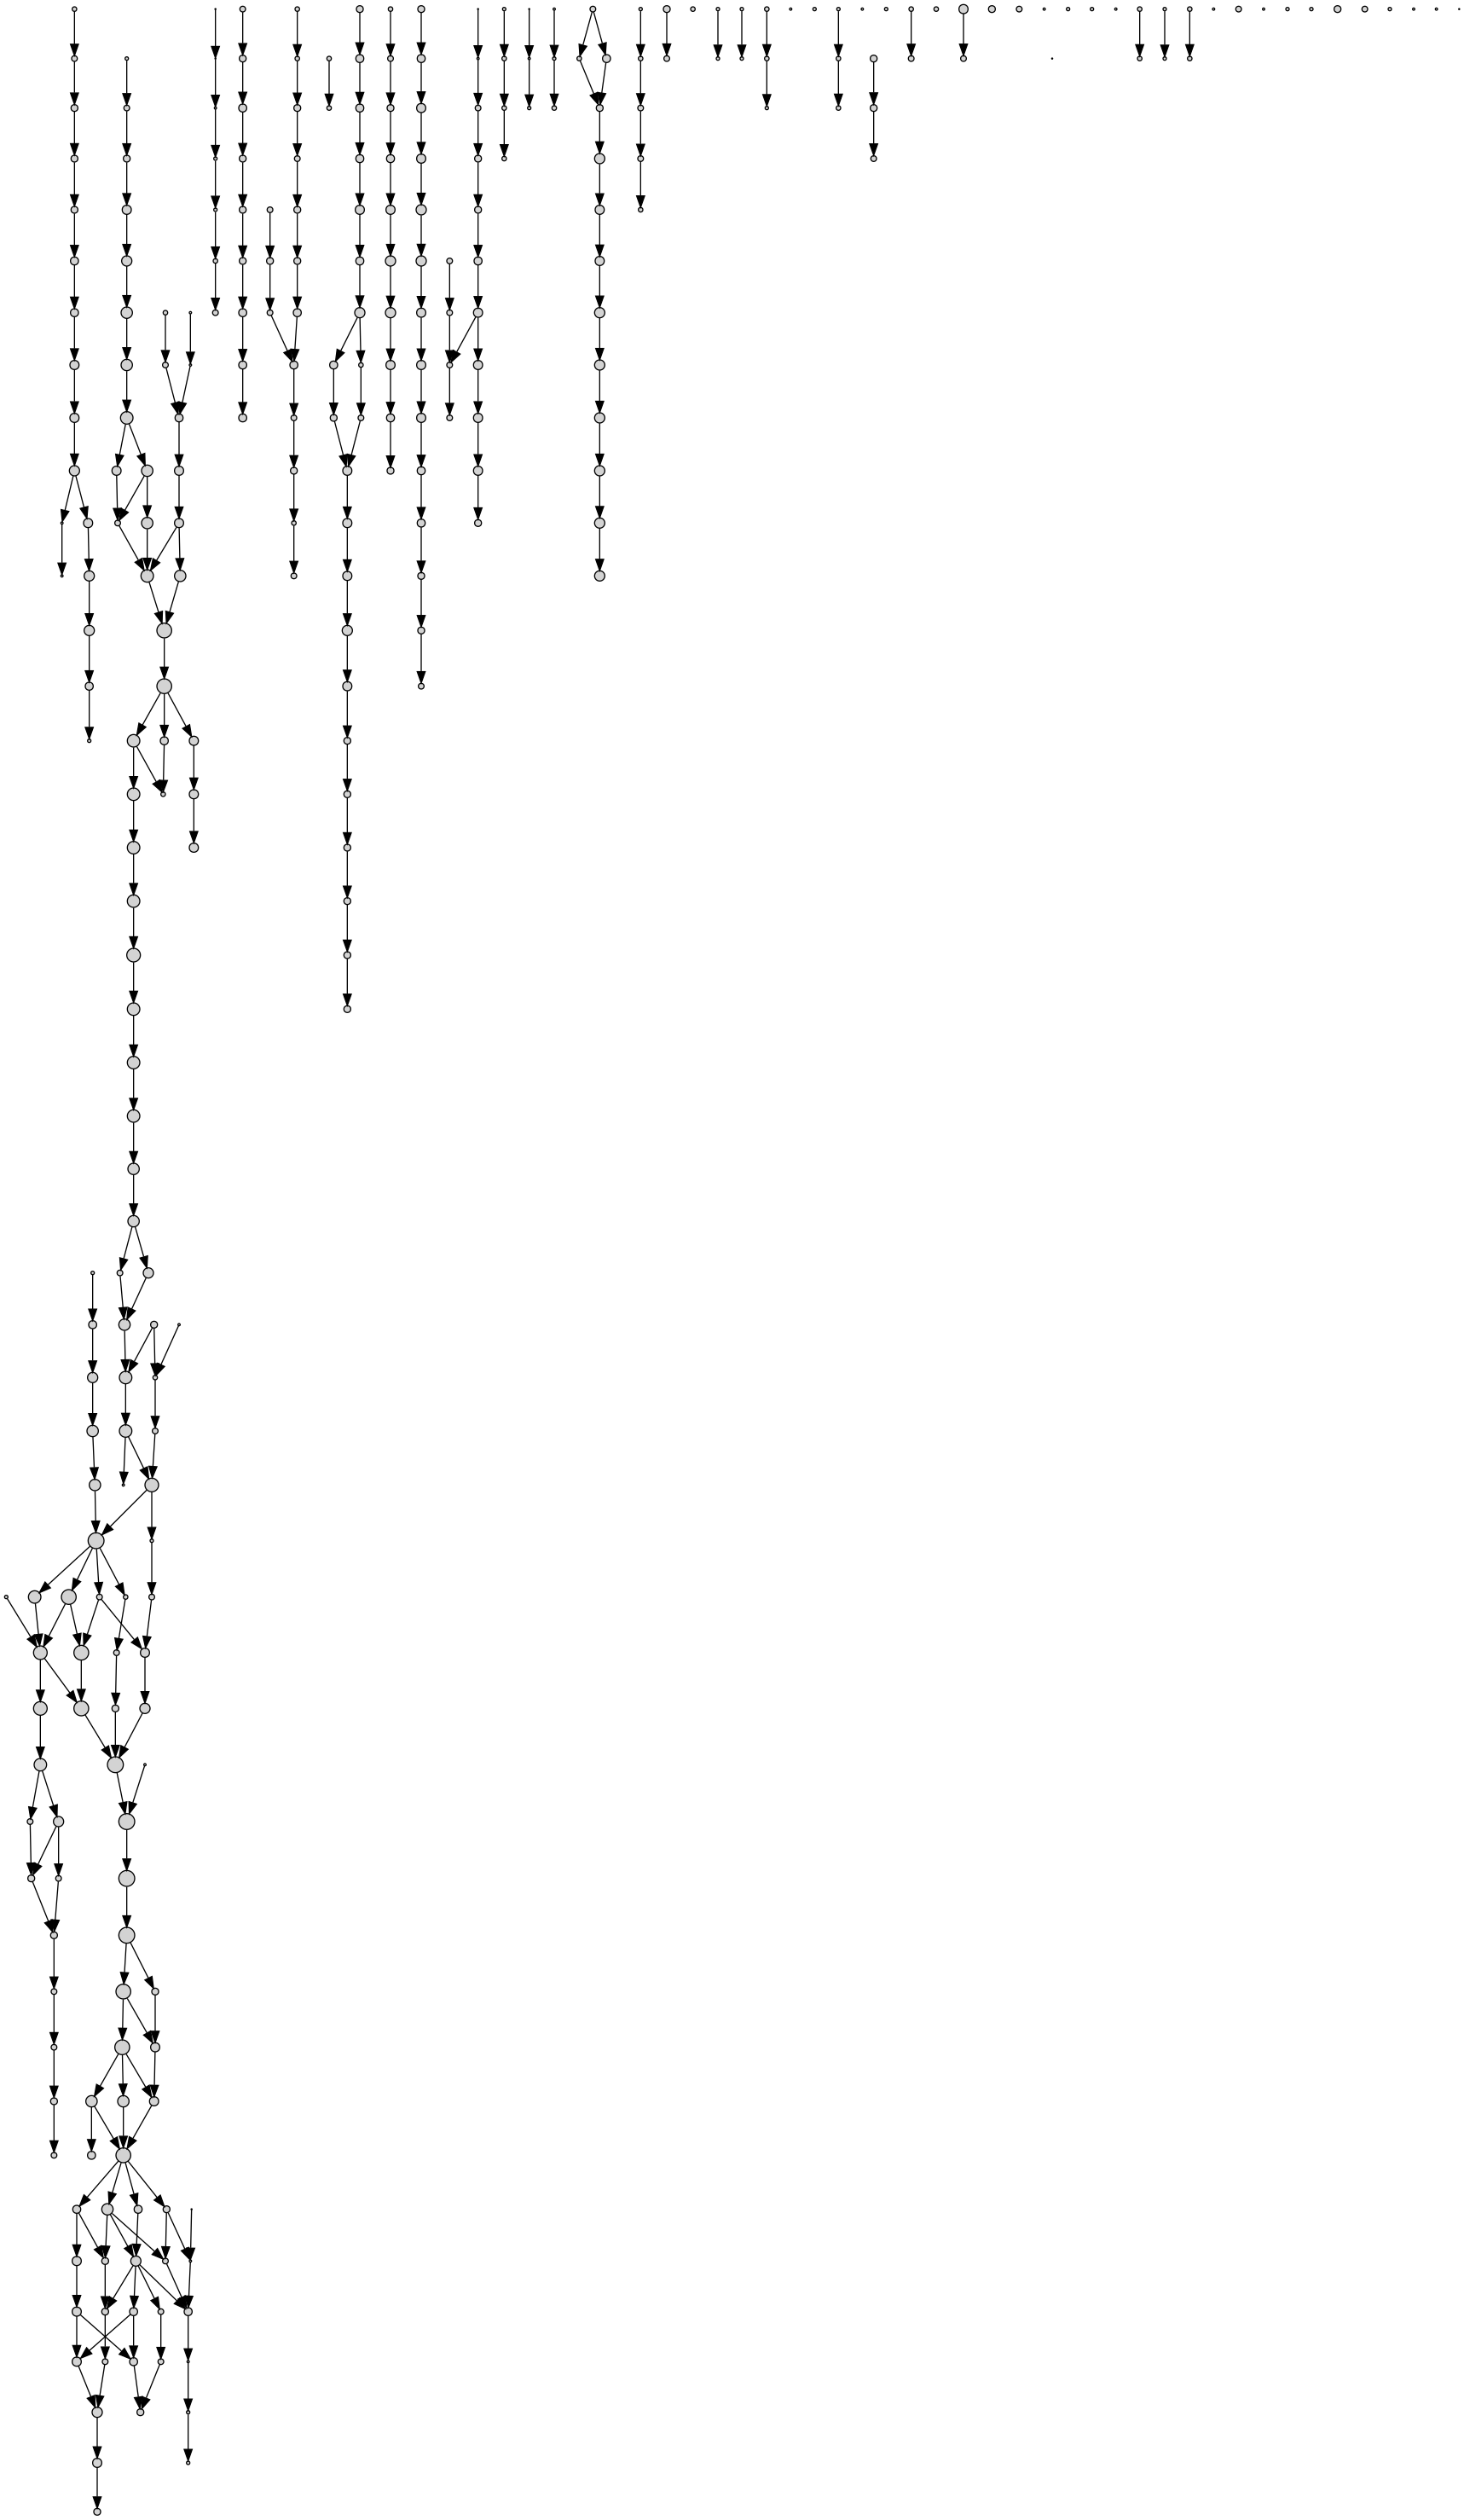

In [13]:
from IPython.display import Image
Image(mergertree_name.replace("pkl", "png"))